In [33]:
import pandas as pd
import konlpy
import gensim
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성

데이터의 중복 확인 후 제거하기

In [9]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [11]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


결측치 제거하기

In [12]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지 확인
print(train_data.isnull().values.any())

True


In [13]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [15]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [16]:
print(len(train_data))

146182


In [18]:
# document 열과 label 열의 중복을 제외한 값의 개수
test_data['document'].nunique(), test_data['label'].nunique()

(49157, 2)

In [20]:
# document 열의 중복 제거
test_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 49158


In [21]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지 확인
print(test_data.isnull().values.any())

True


In [23]:
print(test_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [24]:
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [25]:
print(len(test_data))

49157


한국어 토크나이저로 토큰화 및 불용어 제거, 사전 구성

In [26]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 빈도수 계산
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)  # 상위 num_words-4개의 단어 선택
    
    # 사전 구축
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [27]:
index_to_word = {index:word for word, index in word_to_index.items()}

텍스트 스트링을 인덱스 스트링으로 변환, 리턴

In [28]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.98170773419436


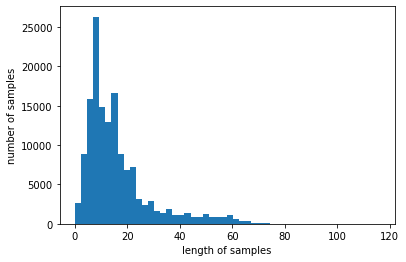

In [34]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [37]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 96.03439547960761


In [39]:
# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=max_len)

# 4. 모델 구성 및 Validation Set 구성

1. LSTM

In [40]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


2. 1D CNN

In [41]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

3. GlobalMaxPooling

In [42]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 개시

In [45]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 50)
(136182,)


In [48]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 35s 7ms/step - loss: 0.4825 - accuracy: 0.7862 - val_loss: 0.3520 - val_accuracy: 0.8475
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3348 - accuracy: 0.8586 - val_loss: 0.3412 - val_accuracy: 0.8527
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3136 - accuracy: 0.8689 - val_loss: 0.3395 - val_accuracy: 0.8562
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3017 - accuracy: 0.8740 - val_loss: 0.3419 - val_accuracy: 0.8536
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2905 - accuracy: 0.8794 - val_loss: 0.3470 - val_accuracy: 0.8524
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2791 - accuracy: 0.8855 - val_loss: 0.3487 - val_accuracy: 0.8532
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2698 - accuracy: 0.8910 - val_loss: 0.3542 - val_accuracy: 0.8539
Epoch

In [49]:
#모델 2 훈련
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 21s 6ms/step - loss: 0.5574 - accuracy: 0.6960 - val_loss: 0.4612 - val_accuracy: 0.7686
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4359 - accuracy: 0.7850 - val_loss: 0.4575 - val_accuracy: 0.7648
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4066 - accuracy: 0.8008 - val_loss: 0.4525 - val_accuracy: 0.7692
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3792 - accuracy: 0.8164 - val_loss: 0.4585 - val_accuracy: 0.7715
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3517 - accuracy: 0.8316 - val_loss: 0.4724 - val_accuracy: 0.7685
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3213 - accuracy: 0.8479 - val_loss: 0.4965 - val_accuracy: 0.7667
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2912 - accuracy: 0.8628 - val_loss: 0.5272 - val_accuracy: 0.7625
Epoch

In [50]:
#모델 3 훈련
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.5668 - accuracy: 0.7761 - val_loss: 0.4048 - val_accuracy: 0.8275
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8446 - val_loss: 0.3493 - val_accuracy: 0.8456
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3186 - accuracy: 0.8657 - val_loss: 0.3399 - val_accuracy: 0.8516
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2928 - accuracy: 0.8785 - val_loss: 0.3404 - val_accuracy: 0.8498
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2730 - accuracy: 0.8888 - val_loss: 0.3448 - val_accuracy: 0.8507
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2569 - accuracy: 0.8962 - val_loss: 0.3521 - val_accuracy: 0.8495
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.2429 - accuracy: 0.9030 - val_loss: 0.3596 - val_accuracy: 0.8501
Epoch 

# 6. Loss, Accuracy 그래프 시각화

In [53]:
# 모델 학습 및 결과 저장, 그래프 그리기 함수
def loss_acc_graph(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # 손실(Loss) 그래프
    plt.plot(epochs, loss, 'bo', label='Training loss')  # "bo"는 "파란색 점"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # "b"는 "파란 실선"
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # 정확도(Accuracy) 그래프
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 1/20
266/266 [==============================] - 1s 6ms/step - loss: 0.1533 - accuracy: 0.9426 - val_loss: 0.5284 - val_accuracy: 0.8430
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1485 - accuracy: 0.9441 - val_loss: 0.5496 - val_accuracy: 0.8468
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1432 - accuracy: 0.9465 - val_loss: 0.5645 - val_accuracy: 0.8449
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9485 - val_loss: 0.5745 - val_accuracy: 0.8437
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1339 - accuracy: 0.9503 - val_loss: 0.6068 - val_accuracy: 0.8437
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1295 - accuracy: 0.9522 - val_loss: 0.6430 - val_accuracy: 0.8331
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1288 - accuracy: 0.9520 - val_loss: 0.6400 - val_accuracy: 0.8396
Epoch 

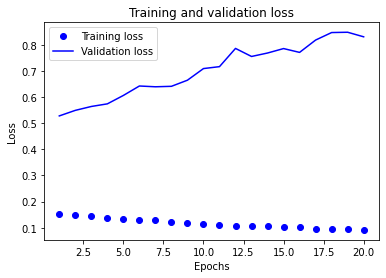

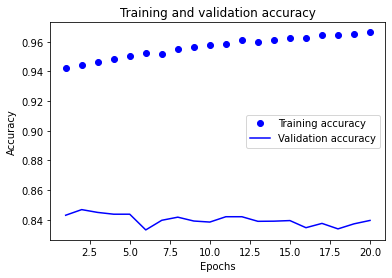

Epoch 1/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1448 - accuracy: 0.9241 - val_loss: 1.2014 - val_accuracy: 0.7365
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1435 - accuracy: 0.9233 - val_loss: 1.2230 - val_accuracy: 0.7416
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1420 - accuracy: 0.9244 - val_loss: 1.3135 - val_accuracy: 0.7363
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1396 - accuracy: 0.9247 - val_loss: 1.3156 - val_accuracy: 0.7390
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1382 - accuracy: 0.9254 - val_loss: 1.3552 - val_accuracy: 0.7319
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1362 - accuracy: 0.9259 - val_loss: 1.4021 - val_accuracy: 0.7412
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.1352 - accuracy: 0.9269 - val_loss: 1.4480 - val_accuracy: 0.7360
Epoch 

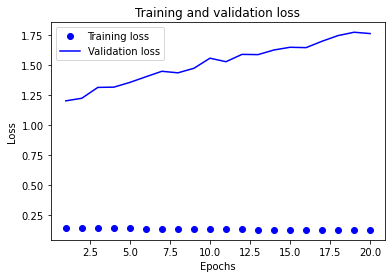

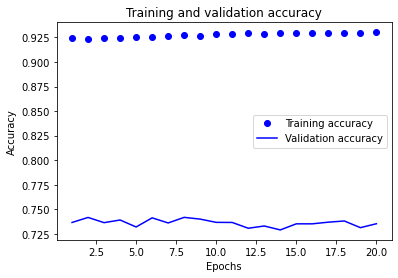

Epoch 1/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1405 - accuracy: 0.9514 - val_loss: 0.5279 - val_accuracy: 0.8288
Epoch 2/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1367 - accuracy: 0.9525 - val_loss: 0.5425 - val_accuracy: 0.8265
Epoch 3/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1332 - accuracy: 0.9545 - val_loss: 0.5542 - val_accuracy: 0.8262
Epoch 4/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1294 - accuracy: 0.9561 - val_loss: 0.5666 - val_accuracy: 0.8238
Epoch 5/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9573 - val_loss: 0.5759 - val_accuracy: 0.8234
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1229 - accuracy: 0.9584 - val_loss: 0.5920 - val_accuracy: 0.8234
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.1204 - accuracy: 0.9597 - val_loss: 0.6031 - val_accuracy: 0.8230
Epoch 

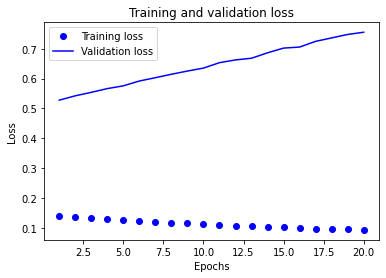

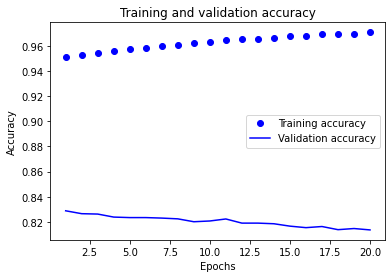

In [55]:
# 모델 학습 및 결과 출력
history1 = model1.fit(partial_X_train, partial_y_train,
                      epochs=epochs, batch_size=512,
                      validation_data=(x_val, y_val), verbose=1)

results1 = model1.evaluate(X_test, y_test, verbose=2)
print('Model 1 Results:', results1)
loss_acc_graph(history1.history)

history2 = model2.fit(partial_X_train, partial_y_train,
                      epochs=epochs, batch_size=512,
                      validation_data=(x_val, y_val), verbose=1)

results2 = model2.evaluate(X_test, y_test, verbose=2)
print('Model 2 Results:', results2)
loss_acc_graph(history2.history)

history3 = model3.fit(partial_X_train, partial_y_train,
                      epochs=epochs, batch_size=512,
                      validation_data=(x_val, y_val), verbose=1)

results3 = model3.evaluate(X_test, y_test, verbose=2)
print('Model 3 Results:', results3)
loss_acc_graph(history3.history)

# 7. 학습된 Embedding 레이어 분석

 모델이 훈련 데이터에 과적합됨

# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [59]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 경로를 절대 경로로 변환
word2vec_file_path = os.path.expanduser('~/data/word2vec_ko.model')

# 모델 로드
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)

In [60]:
# 예시 변수들
vocab_size = 10000  # 단어 집합 크기
word_vector_dim = 100  # 워드 벡터 차원

# 무작위로 초기화된 embedding_matrix
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# index_to_word와 word_vectors.wv를 사용해 embedding_matrix를 채우는 코드
for i in range(4, vocab_size):  # 만약 0번이 패딩이라면 1부터 시작
    word = index_to_word[i]  # index_to_word가 단어 집합일 것으로 가정
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word]
    else:
        # word2vec에 없는 단어는 랜덤 벡터 유지 또는 무시
        continue

In [63]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential

# Word2Vec 임베딩을 적용한 embedding_matrix 사용 예시
# vocab_size와 word_vector_dim은 이미 정의된 상태

# 모델을 생성하는 함수 정의 (모델 1, 2, 3에 동일하게 적용)
def create_model1(vocab_size, word_vector_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=word_vector_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False))  # 임베딩 훈련하지 않음
    model.add(LSTM(128))  # 예시로 LSTM 레이어 사용
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_model2(vocab_size, word_vector_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=word_vector_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False))
    model.add(GRU(128))  # GRU 사용
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_model3(vocab_size, word_vector_dim, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=word_vector_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_len, 
                        trainable=False))
    model.add(Bidirectional(LSTM(128)))  # 양방향 LSTM 사용
    model.add(Dense(1, activation='sigmoid'))
    return model

In [64]:
# 임베딩 매트릭스 (Word2Vec 모델에서 만든 것을 사용)
# 모델 1, 2, 3 생성
model1 = create_model1(vocab_size, word_vector_dim, embedding_matrix)
model2 = create_model2(vocab_size, word_vector_dim, embedding_matrix)
model3 = create_model3(vocab_size, word_vector_dim, embedding_matrix)

# 컴파일 및 학습 절차 (모델 1)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model1.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

# 모델 2
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

# 모델 3
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(partial_X_train,
                      partial_y_train,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 11ms/step - loss: 0.4898 - accuracy: 0.7586 - val_loss: 0.4134 - val_accuracy: 0.8154
Epoch 2/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3926 - accuracy: 0.8214 - val_loss: 0.3791 - val_accuracy: 0.8298
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3554 - accuracy: 0.8420 - val_loss: 0.3684 - val_accuracy: 0.8316
Epoch 4/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3288 - accuracy: 0.8552 - val_loss: 0.3545 - val_accuracy: 0.8394
Epoch 5/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3082 - accuracy: 0.8652 - val_loss: 0.3622 - val_accuracy: 0.8411
Epoch 6/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2888 - accuracy: 0.8747 - val_loss: 0.3702 - val_accuracy: 0.8393
Epoch 7/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2726 - accuracy: 0.8829 - val_loss: 0.3572 - val_accuracy: 0.8446

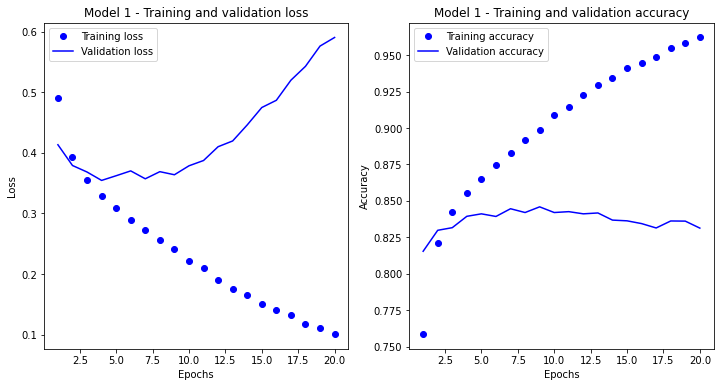

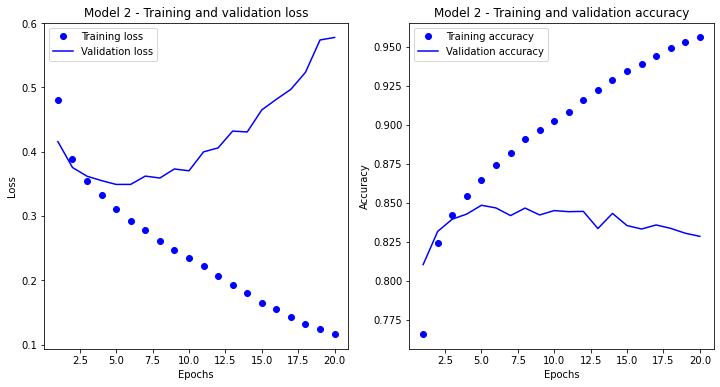

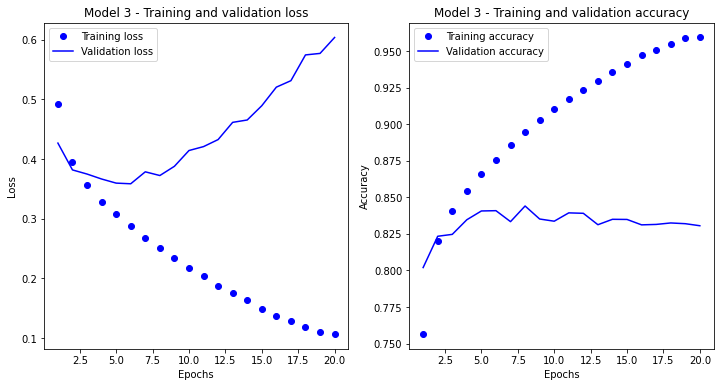

In [65]:
def plot_loss_acc(history, model_name):
    # 학습 이력(history)에서 손실(loss) 및 정확도(accuracy) 데이터를 추출
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # 손실(Loss) 그래프
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{model_name} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # 정확도(Accuracy) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{model_name} - Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# 각 모델의 학습 결과를 평가하는 그래프 출력
plot_loss_acc(history1, "Model 1")
plot_loss_acc(history2, "Model 2")
plot_loss_acc(history3, "Model 3")

# 회고

과적합 문제가 발생했는데 어떻게 해야할지 모르겠음.
올림픽 정신으로 노드 제출에 의의를 두겠음........................